In [42]:
%matplotlib inline
#%config InlineBackend.figure_format='retina'
import matplotlib.pylab as plt
import seaborn
import pandas as pd
import numpy as np
import statsmodels.api as sm
font = {'family' : 'VL Gothic'}
plt.rc('font', **font)
seaborn.set(style='ticks', context='talk', font='VL Gothic')
seaborn.set_palette("tab10", n_colors=24)
plt.rcParams['figure.figsize'] = [10.0, 7.0]

# Correlation

* https://anomaly.io/understand-auto-cross-correlation-normalized-shift/

## Cross Correlation

* 2つの波の相関をとる。
* ```numpy.correlate(a,b,'full')```
  * correlateとなっているけど偏差の積の和だけで、平均とか標準偏差で割ってない
  * fullにすると片方を1つずつシフトして相関をだす(シフトはないところを0埋めしてるだけ)
* ```statsmodels.ccf```
  * numpyをベースにしているけどcorrelationになるように調整(平均して標準偏差で割ってる)
  * numpyのfullと同じようにシフトして相関をだす(こちらも0埋め)
* ```pandas.DataFrame.corr```
  * 各列のcorrelationを全部出す
  * タイムシフトはしない


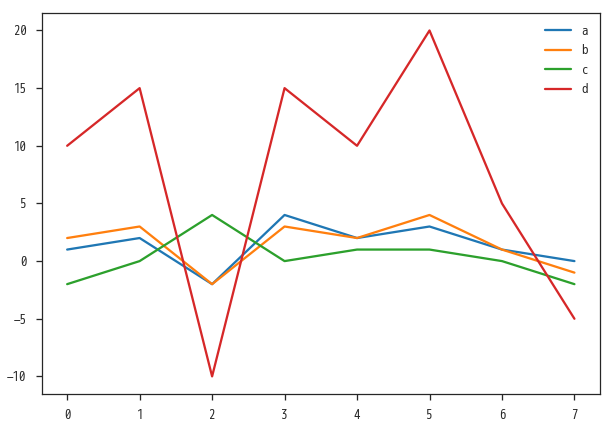

In [43]:
a = [ 1, 2,-2, 4, 2, 3, 1, 0]
b = [ 2, 3,-2, 3, 2, 4, 1,-1]
c = [-2, 0, 4, 0, 1, 1, 0,-2]
df = pd.DataFrame({'a': a, 'b': b, 'c': c})
df['d'] = df['b'] * 5
df.plot()

In [44]:
df.corr()

,a,b,c,d
a,1.000000,0.915448,-0.314094,0.915448
b,0.915448,1.000000,-0.253086,1.000000
c,-0.314094,-0.253086,1.000000,-0.253086
d,0.915448,1.000000,-0.253086,1.000000


* aとbは似ている、aとcは似てない。
* dはbの値を5倍にしているだけなのでbとdは相関1

In [45]:
r = sm.tsa.stattools.ccf(df['a'],df['b'])
r

array([ 0.91544818, -0.53112008, -0.05604785, -0.28023924,  0.14946093,
        0.50443063, -0.33628709, -0.20550878])

* statsmodelsのccfだと、時間を1つずつずらした波との相関も比較している。
* numpy.correlateに依存しているので、どうやってずらしているかnumpy.correlateの動作を確認

In [46]:
np.correlate([1,2,3],[0,1,0.5],'full')

array([0.5, 2. , 3.5, 3. , 0. ])

In [47]:
np.correlate([1,2,3],[0,1,0.5])

array([3.5])

In [48]:
np.correlate([1,2,3],[1,0.5,0])

array([2.])

In [49]:
np.correlate([1,2,3],[0.5,0,0])

array([0.5])

In [50]:
np.correlate([1,2,3],[0,0,1])

array([3])

In [51]:
np.correlate([1,2,3],[0,0,0])

array([0])

* 片方の波をシフトしてデータがないところは0埋めして相関を出していた。

* statsmodels.ccfの計算を分解。
* 0埋めした箇所を補正するために割る数をシフトした数で変動させている。(以下のdの値)

In [52]:
n = len(df['a'])
xi = np.ones(n)
d = np.correlate(xi,xi,'full')
d

array([1., 2., 3., 4., 5., 6., 7., 8., 7., 6., 5., 4., 3., 2., 1.])

In [53]:
xo = df['a']-np.mean(df['a'])
yo = df['b']-np.mean(df['b'])
(np.correlate(xo, yo,'full') / d) / (np.std(df['a']) * np.std(df['b']))

array([ 0.28023924, -0.20550878,  0.71616695, -0.26155662, -0.69125679,
        0.13700585, -0.20550878,  0.91544818, -0.53112008, -0.05604785,
       -0.28023924,  0.14946093,  0.50443063, -0.33628709, -0.20550878])

* statsmodelsのccfは0埋めしてtimeshiftするので合致する部分を探すのには向かない。
* pandas.df.rolling.corrでできそう。

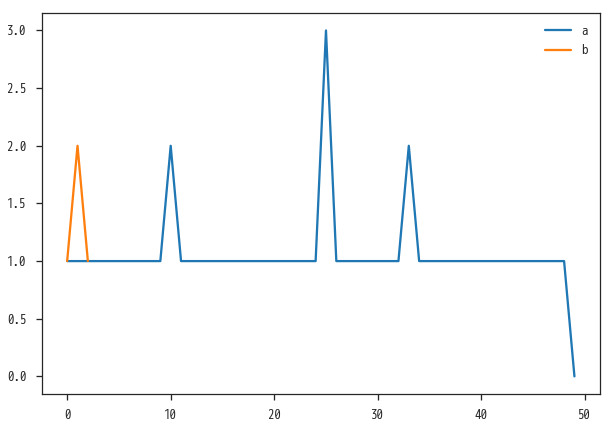

In [154]:
a = np.full((50,),1)
a[10] = 2
a[25] = 3
a[33] = 2
a[49] = 0
a = pd.Series(a)
a.plot(label='a')
b = np.full((3,),1)
b[1] = 2
b = pd.Series(b)
b.plot(label='b')
plt.legend()

* 上記でbを動かしていってaとマッチするところを見つけたい。
  * 10, 25, 33あたりを見つけてほしい。

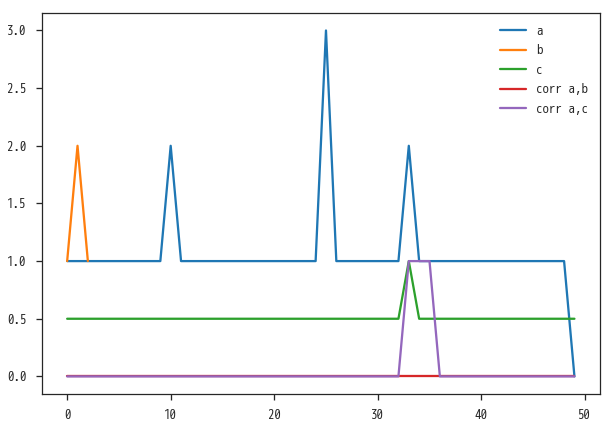

In [162]:
a.plot(label='a')
b.plot(label='b')
c = np.full((50,),0.5)
c[33] = 1
c = pd.Series(c)
c.plot(label='c')
a.rolling(3).corr(b).fillna(0).plot(label='corr a,b')
a.rolling(3).corr(c).fillna(0).plot(label='corr a,c')
plt.legend()

* ```a.rolling().corr(b)```はaとbを同時にWindowを動かしてしまうためa,bの相関はなし。
* ```a.rolling().corr(c)```は33付近でともにピークがあるためここは相関高い。

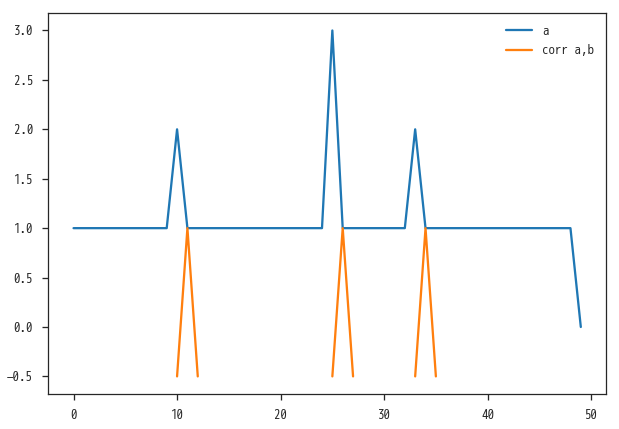

In [165]:
a.plot(label='a')
def mycorr(x):
    return pd.Series(x).corr(b)
a.rolling(window=3).apply(mycorr).plot(label='corr a,b')
plt.legend()

* applyでaのrollingとbそのものの相関をとればよい